Пример на более крупной базе:

https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch

Более лаконичный пример на tf+keras

https://proproprogs.ru/neural_network/kak-delat-sentiment-analiz-rekurrentnoy-lstm-setyu

In [1]:
# !wget -r https://github.com/ankislyakov/data/raw/main/сентименты.xlsx

In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# на всякий случай проверим есть ли у нас GPU
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
df = pd.read_excel('github.com/ankislyakov/data/raw/main/сентименты.xlsx')
df.sample(5)

,review,sentiment
549,негатив разрушает,negative
162,"Лучше блюдо зелени, и при нем любовь, нежели о...",positive
472,Эксель не работает,negative
412,"Даже не начинай, все равно ничего не получится",negative
429,Твоя жизнь не имеет смысла,negative


In [5]:
X,y = df['review'].values,df['sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size=0.33)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (410,)
shape of test data is (202,)


In [6]:
x_test = x_test[:-2]
y_test = y_test[:-2]

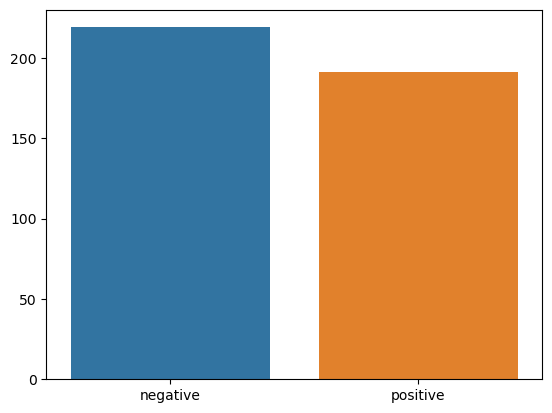

In [7]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [8]:
# пример функции для очистки нашего текста
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\ufeff", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    s = re.sub(r"\n", '', s)
    return s

In [9]:
word_list = []
for sent in x_train:
    for word in sent.lower().split():
        word = preprocess_string(word)
        word_list.append(word)
corpus = Counter(word_list)

corpus_ = sorted(corpus,key=corpus.get,reverse=True)
# создаем словарь
onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

In [10]:
final_list_train,final_list_test = [],[]
for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

encoded_train = [1 if label =='positive' else 0 for label in y_train]
encoded_test = [1 if label =='positive' else 0 for label in y_test]

In [11]:
print(f'Length of vocabulary is {len(onehot_dict)}')

Length of vocabulary is 1224


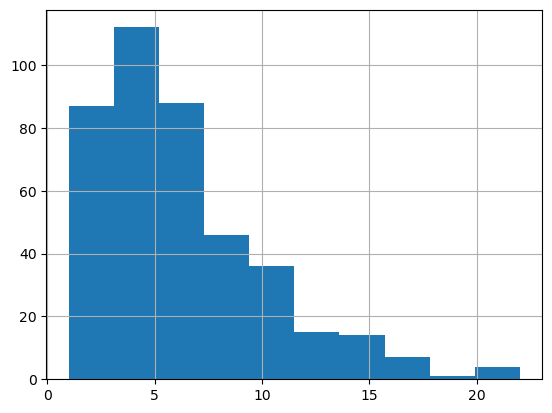

count    410.000000
mean       6.492683
std        3.728066
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       22.000000
dtype: float64

In [12]:
rev_len = [len(i) for i in final_list_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [13]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [14]:
#we have very less number of reviews with length > 10.
#So we will consideronly those below it.
x_train_pad = padding_(final_list_train,10)
x_test_pad = padding_(final_list_test,10)

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(np.array(encoded_train)))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(np.array(encoded_test)))

# dataloaders
batch_size = 10

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [16]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([10, 10])
Sample input: 
 tensor([[   0,    0,    0,    0,  185,   79,   24,    5,  186,  403],
        [   0,    0,    0,    0,    0,    0,    0,    2,   39,  196],
        [   0,  158,  336,  337,  109,   11,  338,  339,   25,  340],
        [   0,    0,    0,    0,  131,  763,  145,  764,    4,   38],
        [  42,  228,  165,  113,   47,    1,  229,   11,   13,  564],
        [   0,    0,    0,    0,    0, 1190,  148, 1191,    1,  273],
        [ 501,   33,   56,    1,   16,  502,  503,   16,  504,  505],
        [   0,    0,    1,  765,  766,   10,  767,  167,    4,  768],
        [   0,    0,    0,    0,    0,    0,  587,  235,  588,  589],
        [   0,    0,    0,    0,   18,  290,    9, 1038,    3,  245]])
Sample input: 
 tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])


In [17]:
no_layers = 2
vocab_size = len(onehot_dict)+1
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [18]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # Слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout()

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # получаем последнюю партию меток

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        # инициализация скрытого слоя
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [19]:
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1225, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [21]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # вычисляем accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` помогает предотвратить проблему взрывающегося градиента в RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}\n')

Epoch 1
train_loss : 0.6760577501320257 val_loss : 0.6467095196247101
train_accuracy : 58.048780487804876 val_accuracy : 67.0

Epoch 2
train_loss : 0.5809634226124462 val_loss : 0.6118009120225907
train_accuracy : 74.8780487804878 val_accuracy : 67.5

Epoch 3
train_loss : 0.4416795354790804 val_loss : 0.6434360399842263
train_accuracy : 80.97560975609757 val_accuracy : 65.5

Epoch 4
train_loss : 0.3301891851715925 val_loss : 0.7099052488803863
train_accuracy : 86.34146341463415 val_accuracy : 62.5

Epoch 5
train_loss : 0.2398933491147146 val_loss : 0.7067380629479885
train_accuracy : 91.95121951219512 val_accuracy : 65.5

Epoch 6
train_loss : 0.11840710284688123 val_loss : 0.8988764069974422
train_accuracy : 95.60975609756098 val_accuracy : 64.5

Epoch 7
train_loss : 0.07521667332025017 val_loss : 1.1465751484036446
train_accuracy : 97.07317073170731 val_accuracy : 66.0

Epoch 8
train_loss : 0.04469137459357337 val_loss : 1.1333434939384461
train_accuracy : 98.53658536585365 val_accura

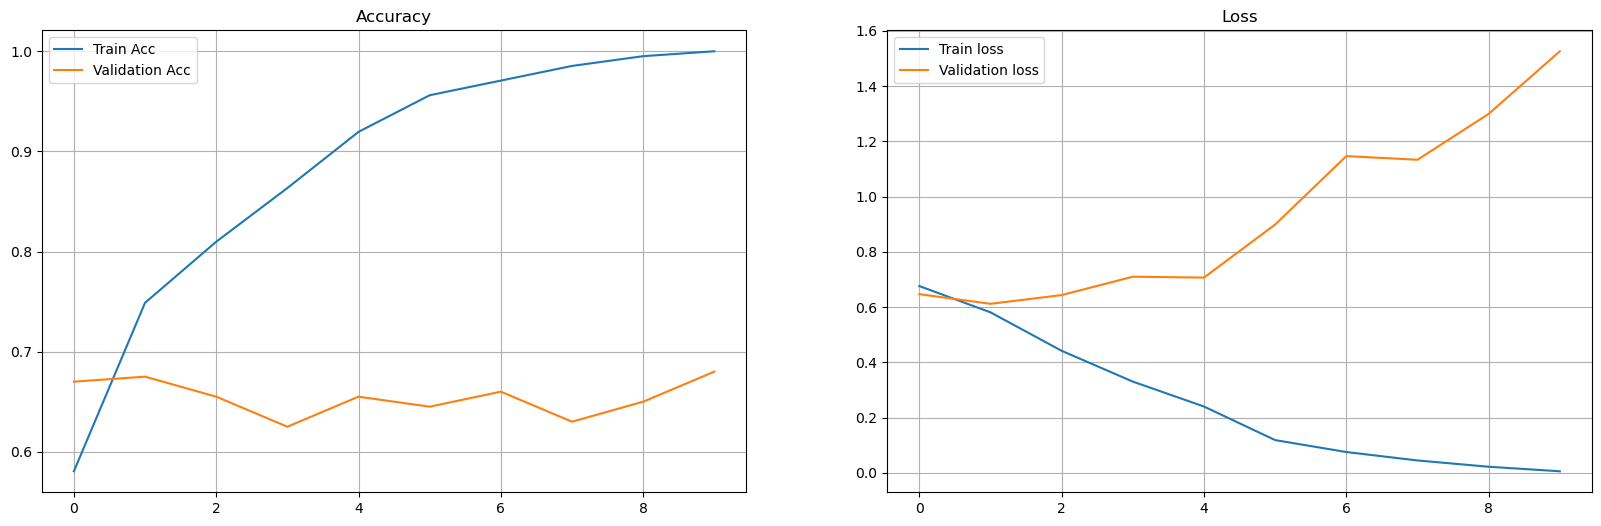

In [22]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [23]:
def predict_text(text):
        word_seq = np.array([onehot_dict[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in onehot_dict.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [24]:
index = np.random.randint(0,len(df))
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

На мгновение отвлекись от проблем и сосредоточься на положительных возможностях.
Actual sentiment is  : positive
Predicted sentiment is negative with a probability of 0.9996639638848137


In [25]:
# Собственный вариант
pro = predict_text('Люби всех!!!!!!!!!!')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.6382166743278503


In [26]:
word_list

['скоро',
 'состоится',
 'встреча',
 'с',
 'дальними',
 'родственниками',
 'я',
 'никогда',
 'не',
 'сяду',
 'за',
 'руль',
 'это',
 'же',
 'смертельно',
 'опасно',
 'пробки',
 'на',
 'дорогах',
 'поэтому',
 'долго',
 'добераюсь',
 'ты',
 'навсегда',
 'останешься',
 'пропащим',
 'нельзя',
 'быть',
 'в',
 'коллективе',
 'самым',
 'умным',
 'этого',
 'никто',
 'не',
 'любит',
 'мир',
 'во',
 'всем',
 'мире',
 'у',
 'меня',
 'ничего',
 'не',
 'получится',
 'мужики',
 'все',
 'бесчувственные',
 'сиди',
 'и',
 'помалкивай',
 'пока',
 'тебя',
 'лично',
 'поименно',
 'и',
 'прямо',
 'не',
 'спросили',
 'у',
 'меня',
 'насморк',
 'не',
 'критикуй',
 'а',
 'поощряй',
 'не',
 'просто',
 'возьми',
 'а',
 'дай',
 'не',
 'просто',
 'увидь',
 'а',
 'почувствуй',
 'ты',
 'неудачник',
 'это',
 'не',
 'создаст',
 'мне',
 'проблем',
 'я',
 'смогу',
 'всё',
 'что',
 'ни',
 'делается',
 '',
 'к',
 'лучшему',
 'каждый',
 'день',
 'с',
 'утра',
 'и',
 'до',
 'самого',
 'вечера',
 'у',
 'меня',
 'прекрасное'

В силу ограниченности количества фраз наш словарь не охватывает и 1% великого, могучего, правдивого и свободного русского языка, поэтому конечно же модель на фразах, состоящих из слов нашего словаря работают корректно. Однако и при этом семантика фразы не всегда корректна

In [27]:
# Собственный вариант
pro = predict_text('деньги и шопинг')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.9890289064496756


In [28]:
# А в какой фразе у нас это слово встречалось?
df[df['review'].str.contains('шопинг')]

,review,sentiment
335,Женщинам только и подавай: деньги и шопинг,negative


In [29]:
df[df['review'].str.contains('деньги')]

,review,sentiment
335,Женщинам только и подавай: деньги и шопинг,negative
354,Огромные деньги наживают только воровством,negative
355,Честные деньги не бывают большими,negative
364,"Почему такой умный, и такой бедный? Как только...",negative
368,Большие деньги честными не бывают,negative


In [30]:
# Собственный вариант
pro = predict_text('самое главное - это шопинг')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.9999637603759766


In [31]:
df[df['review'].str.contains('самое главное')]

,review,sentiment
76,Одна вещь за один раз. Сначала самое главное. ...,positive
122,Моя семья-моё самое главное богатство.,positive


In [32]:
# Собственный вариант
pro = predict_text('самое главное - это деньги')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.9999632835388184


In [33]:
# Собственный вариант
pro = predict_text('самое главное')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.8898018673062325


In [34]:
# Собственный вариант: яркий пример того, что наша модель "слегка пессимистична"
# т.к. негативных фраз все-таки было чуть-чуть больше
# и те слова, которые модель "не знает" она чаще относит по умолчанию в негатив
pro = predict_text('биполярный транзистор')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is positive with a probability of 0.8641830682754517


In [35]:
# Собственный вариант: яркий пример того, что наша модель "слегка пессимистична"
# т.к. негативных фраз все-таки было чуть-чуть больше
# и те слова, которые модель "не знает" она относит по умолчанию в негатив
pro = predict_text('мама не сварила борщ')
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is negative with a probability of 0.9995986649300903
